## Assignment 3: Pattern Mining and Recommender Systems

### Task 2: Collaborative Filtering
### Lalitphan Sae-teoh, a1932456, Version 01

### Import Libraries

In [3]:
import pandas as pd
import numpy as np

import implicit
from scipy.sparse import csr_matrix

import matplotlib.pyplot as plt
import seaborn as sns

### Read Dataset

In [4]:
df = pd.read_csv('./data/Groceries data train.csv')
df.dropna(subset=["User_id"], inplace=True)
df = df.astype({'User_id': 'int', 'year': 'int', 'month': 'int', 'day': 'int', 'day_of_week': 'int'})
df['datetime'] = pd.to_datetime(df['Date'], dayfirst=True).dt.date
df.set_index('datetime', inplace=True)
df.sort_index(inplace=True)
df.head()

,User_id,Date,itemDescription,year,month,day,day_of_week
datetime,,,,,,,
2014-01-01,2351,1/01/2014,cleaner,2014,1,1,2
2014-01-01,2226,1/01/2014,sausage,2014,1,1,2
2014-01-01,1922,1/01/2014,tropical fruit,2014,1,1,2
2014-01-01,2943,1/01/2014,whole milk,2014,1,1,2
2014-01-01,1249,1/01/2014,citrus fruit,2014,1,1,2


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19382 entries, 2014-01-01 to 2015-01-20
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   User_id          19382 non-null  int32 
 1   Date             19382 non-null  object
 2   itemDescription  19382 non-null  object
 3   year             19382 non-null  int32 
 4   month            19382 non-null  int32 
 5   day              19382 non-null  int32 
 6   day_of_week      19382 non-null  int32 
dtypes: int32(5), object(2)
memory usage: 832.8+ KB


### Data Analysis

In [6]:
len(df)

19382

In [7]:
min_date = df.index.min()
max_date = df.index.max()

print("Minimum date:", min_date)
print("Maximum date:", max_date)

Minimum date: 2014-01-01
Maximum date: 2015-01-20


In [8]:
users = df['User_id'].unique()
print("Total User:\n", len(users))

Total User:
 3493


In [9]:
items = df['itemDescription'].unique()
print("Total:\n", len(items))
print("Items:\n", items[:50])

Total:
 167
Items:
 ['cleaner' 'sausage' 'tropical fruit' 'whole milk' 'citrus fruit' 'onions'
 'other vegetables' 'berries' 'hamburger meat' 'bottled water' 'butter'
 'yogurt' 'waffles' 'soda' 'sliced cheese' 'curd' 'specialty chocolate'
 'shopping bags' 'flower (seeds)' 'coffee' 'whipped/sour cream'
 'frozen potato products' 'candles' 'bottled beer' 'Instant food products'
 'frozen vegetables' 'brown bread' 'domestic eggs' 'dishes' 'chocolate'
 'pip fruit' 'frankfurter' 'sugar' 'beef' 'meat' 'root vegetables'
 'pastry' 'ice cream' 'rolls/buns' 'chicken' 'white bread' 'frozen fish'
 'sparkling wine' 'cream cheese ' 'fruit/vegetable juice' 'condensed milk'
 'soft cheese' 'canned beer' 'candy' 'dessert']


Visualization of Top 20 items

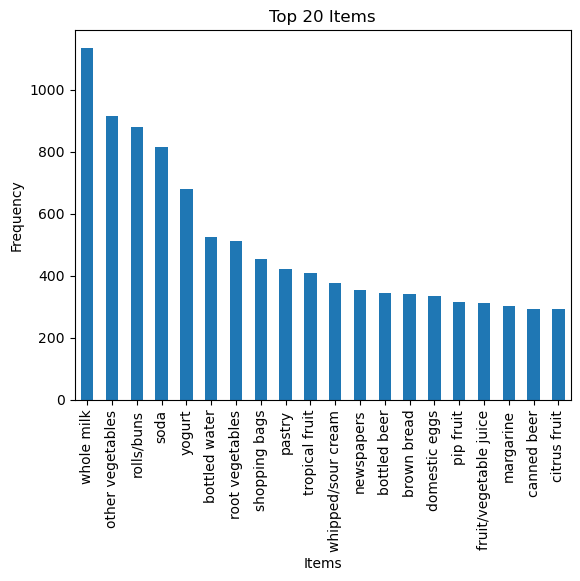

In [47]:
item_counts = df['itemDescription'].value_counts()[:20]

item_counts.plot.bar()
plt.title('Top 20 Items')
plt.xlabel('Items')
plt.ylabel('Frequency')
plt.show()

Visualize Users Purchasing Distribution

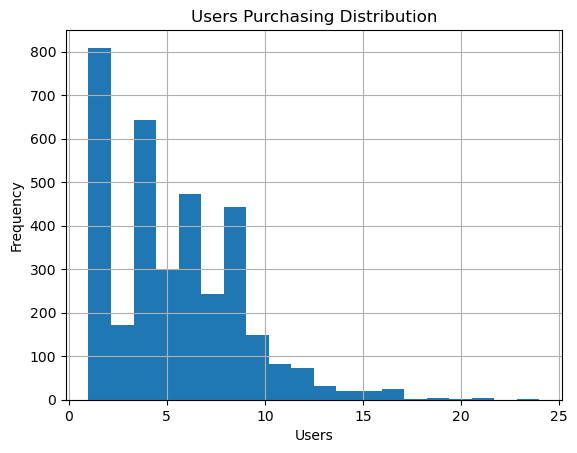

In [59]:
user_purchase_counts = df['User_id'].value_counts()

user_purchase_counts.hist(bins=20)
plt.title('Users Purchasing Distribution')
plt.xlabel('Users')
plt.ylabel('Frequency')
plt.show()

In [60]:
# Top 20 users
user_purchase_counts[:10]

User_id
3247    24
4941    23
1410    21
1169    21
1466    21
3221    20
4272    20
4297    19
1004    19
4683    19
Name: count, dtype: int64

Find average items (total items & unique items) sales / users - for users threshold

In [11]:
df_items_per_users_count = df.groupby('User_id').agg({"itemDescription": ["nunique"]}).reset_index()
df_items_per_users_count.columns = ['User_id', 'unique_items_count']
df_items_per_users_count.head()

,User_id,unique_items_count
0,1000,3
1,1001,5
2,1002,4
3,1003,5
4,1004,15


In [12]:
total_unique_items_sales = df_items_per_users_count['unique_items_count'].sum()
total_users = df_items_per_users_count['User_id'].count()

avg_items_sales_per_user = total_unique_items_sales / total_users
print("Total Users: ", total_users)
print("Total Unique Items Sales: ", total_unique_items_sales)
print(f"Average unique items per user: {avg_items_sales_per_user:.2f}")

Total Users:  3493
Total Unique Items Sales:  18288
Average unique items per user: 5.24


Find popularity of item - average users / items

In [13]:
df_users_per_items_count = df.groupby('itemDescription').agg({"User_id": ["nunique"]}).reset_index()
df_users_per_items_count.columns = ['itemDescription', 'unique_users_count']
df_users_per_items_count.head()

,itemDescription,unique_users_count
0,Instant food products,37
1,UHT-milk,165
2,abrasive cleaner,12
3,artif. sweetener,14
4,baby cosmetics,1


In [14]:
total_users_bought = df_users_per_items_count['unique_users_count'].sum()
total_items = df_users_per_items_count['itemDescription'].count()

avg_users_per_item = total_users_bought / total_items
print("Total Items: ", total_items)
print("Total Users Bought: ", total_users_bought)
print(f"Average unique users per item: {avg_users_per_item:.2f}")

Total Items:  167
Total Users Bought:  18288
Average unique users per item: 109.51


### Data Preprocessing

Filter users who bought less than 5 items

In [ ]:
# items_per_user_threshold = 3

# mask = df_items_per_users_count["unique_items_count"] >= items_per_user_threshold
# valid_users = set(df_items_per_users_count.loc[mask, "User_id"].tolist())
# print(f"total users = {len(users)}, valid users =  {len(valid_users)} ({len(valid_users)/len(users)*100:.2f}%)")

# df_filter_users = df[df["User_id"].isin(valid_users)].copy()
# print(f"Transactions before remove invalid users: {len(df)}")
# print(f"Transactions after remove invalid users: {len(df_filter_users)} ({len(df_filter_users)/len(df)*100:.2f}%)")

total users = 3493, valid users =  2674 (76.55%)
Transactions before remove invalid users: 19382
Transactions after remove invalid users: 17735 (91.50%)


Filter less popular items

In [ ]:
# users_per_item_threshold = 5

# mask = df_users_per_items_count["unique_users_count"] >= users_per_item_threshold
# valid_items = set(df_users_per_items_count.loc[mask, "itemDescription"].tolist())
# print(f"total items = {len(items)}, valid items =  {len(valid_items)} ({len(valid_items)/len(items)*100:.2f}%)")

# df_filter_users_items = df_filter_users[df_filter_users["itemDescription"].isin(valid_items)].copy()
# print(f"Transactions after remove invalid items: {len(df_filter_users_items)} ({len(df_filter_users_items)/len(df)*100:.2f}%)")

total items = 167, valid items =  158 (94.61%)
Transactions after remove invalid items: 17717 (91.41%)


As our dataset is implicit feedback, it would be logical to assign values to every variable. It is set to 0 when there isn't a purchase on record.

In [17]:
df_user_items = df.groupby(['User_id', 'itemDescription']).agg({'Date':['count']}).reset_index()
df_user_items.columns = ['User_id', 'itemDescription', 'Quantity']
user_items_matrix = df_user_items.pivot(index="User_id", columns="itemDescription", values="Quantity")
user_items_matrix.fillna(0, inplace=True)
user_items_matrix

itemDescription,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
User_id,,,,,,,,,,,,,,,,,,,,,
1000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
1002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4993,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [24]:
sparse_matrix = csr_matrix(user_items_matrix.values)
print(sparse_matrix[:3])

  (0, 105)	1.0
  (0, 128)	1.0
  (0, 164)	1.0
  (1, 56)	1.0
  (1, 122)	1.0
  (1, 130)	1.0
  (1, 138)	2.0
  (1, 164)	2.0
  (2, 15)	1.0
  (2, 63)	1.0
  (2, 102)	1.0
  (2, 164)	1.0


### Model Implementation

In [25]:
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight

weighted_matrix = bm25_weight(sparse_matrix.T).T

model = AlternatingLeastSquares(factors=50, regularization=0.1, iterations=20)
model.fit(weighted_matrix)

c:\Users\lalit\anaconda3_2\Lib\site-packages\implicit\cpu\als.py:95: RuntimeWarning: OpenBLAS is configured to use 8 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()
c:\Users\lalit\anaconda3_2\Lib\site-packages\implicit\cpu\als.py:95: RuntimeWarning: Intel MKL BLAS is configured to use 4 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'MKL_NUM_THREADS=1' or by callng 'threadpoolctl.threadpool_limits(1, "blas")'. Having MKL use a threadpool can lead to severe performance issues
  check_blas_config()
c:\Users\lalit\anaconda3_2\Lib\site-packages\implicit\utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0010004043579101562 seconds

  0%|          | 0/20 [00:00<?, ?it/s]

In [37]:
user_mapping = list(user_items_matrix.index)
user_mapping[:5]

[1000, 1001, 1002, 1003, 1004]

In [66]:
# user_id index
user_index = user_mapping.index(1004)
recommended = model.recommend(user_index, sparse_matrix[user_index], N=5)
recommended

(array([  6, 151,  49, 150, 143]),
 array([0.60962766, 0.4456299 , 0.43153936, 0.36012566, 0.34851506],
       dtype=float32))

In [67]:
item_mapping = list(user_items_matrix.columns)
recommended_items = [item_mapping[item_id] for item_id in recommended[0]]
recommended_items

['baking powder', 'sweet spreads', 'domestic eggs', 'sugar', 'specialty bar']

In [68]:
df[df["User_id"] == 1004]

,User_id,Date,itemDescription,year,month,day,day_of_week
datetime,,,,,,,
2014-01-05,1004,5/01/2014,dish cleaner,2014,1,5,6
2014-01-05,1004,5/01/2014,cling film/bags,2014,1,5,6
2014-01-07,1004,7/01/2014,canned beer,2014,1,7,1
2014-01-07,1004,7/01/2014,frozen fish,2014,1,7,1
2014-04-02,1004,2/04/2014,pip fruit,2014,4,2,2
2014-04-02,1004,2/04/2014,whole milk,2014,4,2,2
2014-04-02,1004,2/04/2014,tropical fruit,2014,4,2,2
2014-08-19,1004,19/08/2014,root vegetables,2014,8,19,1
2014-08-19,1004,19/08/2014,whole milk,2014,8,19,1


### Reflection

**Code Version**: version01

* **Stages**: Analyst, Visualized data, Preprocessed data and Implemented base model
* **Progress & Results**: Performed analysis, reseach collaborative filtering methods and implement the first base model.
* **Reflection**: I learned how to analyze transaction data. During data preprocessing, I found that the user-item matrix had many missing values, so I researched the method of handling them. As the dataset is implicit feedback, the missing value can be treated as zero to indicate that there is zero purchasing on that item (Yifan Hu, Koren, Y & Volinsky, C 2008). The first base model used the AlternatingLeastSquares approach.

**Summarize Progress Table** 

| Code Version | Progress & Results                                                                         |
|:-------------|:-------------------------------------------------------------------------------------------|
|version01     |Performed analysis, reseach collaborative filtering methods and implement the first base model.|

### References

| Contribution Part | Reference                  |Citation                                                  |
|:------------------|:---------------------------|:---------------------------------------------------------|
|Data Preprocessing|Users & Items Matrix|Zaishan Weng 2023, 'Quick start guide to build a Collaborative Filtering Recommendation System with implicit library in 4 steps', medium, accessed 23 April 2025,<https://medium.com/@zaishanweng/quick-start-guide-to-build-a-collaborative-filtering-recommendation-system-with-implicit-library-in-c5e79e35dfb8>|
|Data Preprocessing|Data Sparse|Yuki Shizuya 2024, 'Detailed explanation about Collaborative filtering with Python examples', medium, accessed 23 April 2025,<https://medium.com/@ichigo.v.gen12/detailed-explanation-about-collaborative-filtering-eab116e3b28b>|
|Model Implementation|Implicit feedback|Yao-Ting(Teddy) 2019,'Implicit Feedback Recommendation System (II) — Collaborative Filtering', medium, accessed 23 April 2025,<https://medium.com/@teddywang0202/implicit-feedback-recommendation-system-ii-collaborative-filtering-27be600197f1>|
|Model Implementation|Implicit feedback|Yifan Hu, Koren, Y & Volinsky, C 2008, ‘Collaborative Filtering for Implicit Feedback Datasets’, in 2008 Eighth IEEE International Conference on Data Mining, IEEE, pp. 263–272.|
|Machine Learning|Implicit Library|implicit library, https://benfred.github.io/implicit/index.html|
|Machine Learning   |OpenAI ChatGPT|OpenAI’s ChatGPT, personal communication, <https://chatgpt.com/>|